In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet


In [2]:
!pip install iterative-stratification -q

In [3]:
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

df = pd.read_csv("../input/bengaliai-cv19/train.csv")
print(df.head())
df.loc[:, 'kfold'] = -1

df = df.sample(frac=1).reset_index(drop=True)

X = df.image_id.values
y = df[["grapheme_root", "vowel_diacritic", "consonant_diacritic"]].values
mskf = MultilabelStratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(mskf.split(X,y)):
    print("TRAIN: ", trn_, "VAL: ", val_)
    df.loc[val_, "kfold"] = fold

print(df.kfold.value_counts())
df.to_csv("../working/train_folds.csv", index=False)

  image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো
TRAIN:  [     1      3      4 ... 200836 200838 200839] VAL:  [     0      2      5 ... 200827 200834 200837]
TRAIN:  [     0      1      2 ... 200837 200838 200839] VAL:  [     6     24     28 ... 200822 200828 200833]
TRAIN:  [     0      1      2 ... 200837 200838 200839] VAL:  [     3      4      9 ... 200830 200835 200836]
TRAIN:  [     0      1      2 ... 200835 200836 200837] VAL:  [    23     31     53 ... 200831 200838 200839]
TRAIN:  [     0      2      3 ... 200837 200838 200839] VAL:  [     1     22     29 ... 200823 200829 200832]
0    40168
4

In [4]:
## Creating the dataframe
df = pd.read_parquet("../input/bengaliai-cv19/train_image_data_0.parquet")
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [5]:
!mkdir image_pickles

In [6]:
# Creating image pickles
import joblib 
import glob
import tqdm
from tqdm import tqdm

files = glob.glob("../input/bengaliai-cv19/train_*.parquet")
for f in files:
    df = pd.read_parquet(f)
    image_ids = df.image_id.values
    df = df.drop("image_id", axis=1)
    image_array = df.values
    for j, img_id in tqdm(enumerate(image_ids), total=len(image_ids)):
        joblib.dump(image_array[j, :], f"../working/image_pickles/{img_id}.pkl")

100%|██████████| 50210/50210 [00:45<00:00, 1103.10it/s]


In [7]:
from PIL import Image
import albumentations

class BengaliDatasetTrain:
    def __init__(self, folds, img_height, img_width, mean, std):
        df = pd.read_csv("../working/train_folds.csv")
        df = df[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic", "kfold"]]
        df = df[df.kfold.isin(folds)].reset_index(drop=True)
        self.image_ids = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values
        
        if len(folds) == 1:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                                                scale_limit=0.1, 
                                                rotate_limit=5,
                                                p=0.9),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = joblib.load(f"../working/image_pickles/{self.image_ids[item]}.pkl")
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float32), 
            'grapheme_root': torch.tensor(self.grapheme_root[item], dtype=torch.long),
            'vowel_diacritic': torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
            'consonant_diacritic': torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
        }

In [8]:
## Visualizing images
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [9]:
dataset = BengaliDatasetTrain(
    folds=[0,1],
    img_height=137,
    img_width=236,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

In [10]:
len(dataset)

80336

tensor(115)
tensor(1)
tensor(0)


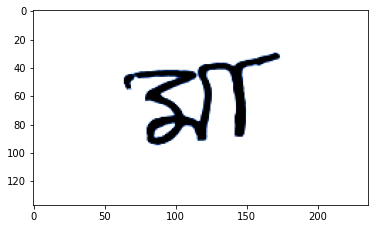

In [11]:
idx = 0
img = dataset[idx]["image"]
print(dataset[idx]["grapheme_root"])
print(dataset[idx]["vowel_diacritic"])
print(dataset[idx]["consonant_diacritic"])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))

tensor(149)
tensor(2)
tensor(0)


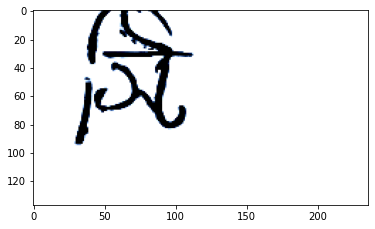

In [12]:
idx = 4000
img = dataset[idx]["image"]
print(dataset[idx]["grapheme_root"])
print(dataset[idx]["vowel_diacritic"])
print(dataset[idx]["consonant_diacritic"])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))

In [15]:
!pip install pretrainedmodels -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8546160cd84e44948ce8ea2b3a7b814caea131f8cb6de28b81eba96afbcd4f1b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [20]:
## https//www.github.com/Cadene/pretrained-models.pytorch
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [22]:
model = ResNet34(pretrained=False)
model

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [19]:
import os
import ast

DEVICE = "cuda"
TRAINING_FOLDS_CSV = os.environ.get("TRAINING_FOLDS_CSV")
IMG_HEIGHT = int(os.environ.get("IMG_HEIGHT"))
IMG_WIDTH = int(os.environ.get("IMG_WIDTH"))
EPOCHS = int(os.environ.get("EPOCHS"))

TRAIN_BATCH_SIZE = int(os.environ.get("TRAIN_BATCH_SIZE"))
TEST_BATCH_SIZE = int(os.environ.get("TEST_BATCH_SIZE"))

MODEL_MEAN = ast.literal_eval(os.environ.get("MODEL_MEAN"))
MODEL_STD = ast.literal_eval(os.environ.get("MODEL_STD"))

TRAINING_FOLDS = ast.literal_eval(os.environ.get("TRAINING_FOLDS"))
VALIDATION_FOLDS = ast.literal_eval(os.environ.get("VALIDATION_FOLDS"))

BASE_MODEL = int(os.environ.get("BASE_MODEL"))

def train(dataset, data_loader, model, optimizer):
    model.train()
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        image = d["image"]
        grapheme_root = d["grapheme_root"]
        vowel_diacritic = d["vowel_diacritic"]
        consonant_diacritic = d['consonant_diacritic']
        
        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_fn(output, targets)
        
        loss.backward()
        optimizer.step()
        
def evaluate(dataset, data_loader, model):
    model.eval()
    final_loss = 0
    counter=0
    
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        counter = counter + 1
        image = d["image"]
        grapheme_root = d["grapheme_root"]
        vowel_diacritic = d["vowel_diacritic"]
        consonant_diacritic = d['consonant_diacritic']
        
        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)
        
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_fn(output, targets)
        final_loss += loss
    return final_loss/counter

def loss_fn(outputs, targets):
    o1, o2, o3 = outputs, 
    t1, t2, t3 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    l3 = nn.CrossEntropyLoss()(o3, t3)
    return (l1 + l2 + l3) / 3
        
model = ResNet34(pretrained=True)
model.to(DEVICE)

train_dataset = BengaliDatasetTrain(
    folds = TRAINING_FOLDS,
    img_height = IMG_HEIGHT,
    img_width = IMG_WIDTH,
    mean = MODEL_MEAN,
    std = MODEL_STD
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

valid_dataset = BengaliDatasetTrain(
    folds = VALIDATION_FOLDS,
    img_height = IMG_HEIGHT,
    img_width = IMG_WIDTH,
    mean = MODEL_MEAN,
    std = MODEL_STD
)

valid_loader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, model="min", 
                                                       patience=5, factor=0.3, verbose=True)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel()
    
for epoch in range(EPOCHS):
    train()
    val_score = evaluate()
    scheduler.step(val_score)
    torch.save(model.state_dict(), f"{BASE_MODEL}_fold{VALIDATION_FOLDS[0]}.bin")

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
export CUDA_VISIBLE_DEVICES=0
export IMG_HEIGHT=137
export IMG_WIDTH=236
export EPOCHS = 50
export TRAIN_BATCH_SIZE = 64
export TEST_BATCH_SIZE = 8
export MODEL_MEAN = ""
export MODEL_STD = ""

export TRAINING_FOLDS = "(0,1,2,3)"
export VALIDATION_FOLDS = ""